In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [2]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Weronika\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [4]:
df = pd.read_csv("data/fake-news-train.csv")
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.head(10)

,index,id,title,author,text,label
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
7,9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0
8,10,10,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",0
9,11,11,"BBC Comedy Sketch ""Real Housewives of ISIS"" Ca...",Chris Tomlinson,The BBC produced spoof on the “Real Housewives...,0


In [5]:
X = df["title"]
y = df["label"]

In [8]:
ps = PorterStemmer()
corpus = []

for i in range(len(X)):
    text = X[i]
    text = re.sub('[^a-zA-Z]', ' ', text) # replace everything that's not an alphabet by a space
    text = text.lower()
    text = text.split()
    text = [ps.stem(t) for t in text if t not in stopwords.words("english")]
    corpus.append(' '.join(text))

In [9]:
vocab_size = 5_000
sent_len = 20

# encode text data to numerical data
# assign a random number using hashing to the word.
# the random word is chosen from the range 0-vocab_size
one_hot_encoded = [one_hot(x, vocab_size) for x in corpus]

# pad the sentences with 0s to make every line of the same length
one_hot_encoded = pad_sequences(one_hot_encoded, maxlen=sent_len)
one_hot_encoded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 2183,
       1584,  111, 3746, 4979,  946, 3462, 4759, 4680,   21])

In [10]:
X = np.array(one_hot_encoded)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2021)

In [12]:
no_of_output_features = 40

model = Sequential([
    Embedding(vocab_size, no_of_output_features, input_length=sent_len),
    Dropout(0.5),
    LSTM(100),
    Dropout(0.5),
    Dense(1)
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor="loss", patience=5)

In [15]:
his = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, 
                epochs=80, callbacks=[callback])

Epoch 1/80
192/192 [==============================] - 55s 33ms/step - loss: 0.4397 - accuracy: 0.8028 - val_loss: 0.2559 - val_accuracy: 0.9006
Epoch 2/80
192/192 [==============================] - 3s 16ms/step - loss: 0.2319 - accuracy: 0.9200 - val_loss: 0.2407 - val_accuracy: 0.9180
Epoch 3/80
192/192 [==============================] - 3s 15ms/step - loss: 0.2035 - accuracy: 0.9380 - val_loss: 0.3621 - val_accuracy: 0.9213
Epoch 4/80
192/192 [==============================] - 3s 14ms/step - loss: 0.2008 - accuracy: 0.9377 - val_loss: 0.3338 - val_accuracy: 0.9150
Epoch 5/80
192/192 [==============================] - 3s 15ms/step - loss: 0.1678 - accuracy: 0.9536 - val_loss: 0.4265 - val_accuracy: 0.9190
Epoch 6/80
192/192 [==============================] - 2s 13ms/step - loss: 0.1491 - accuracy: 0.9654 - val_loss: 0.4576 - val_accuracy: 0.9180
Epoch 7/80
192/192 [==============================] - 3s 15ms/step - loss: 0.1537 - accuracy: 0.9601 - val_loss: 0.4771 - val_accuracy: 0.917

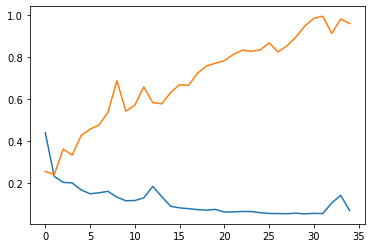

In [18]:
import matplotlib.pyplot as plt

plt.plot(his.history["loss"])
plt.plot(his.history["val_loss"])
plt.show()

## CLEARLY UNDERFITTING

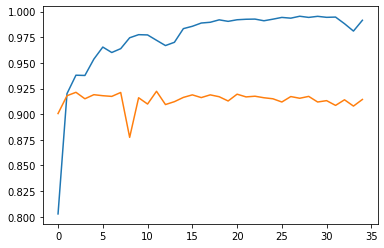

In [19]:
plt.plot(his.history["accuracy"])
plt.plot(his.history["val_accuracy"])
plt.show()

In [20]:
pred = model.predict_classes(X_test)
confusion_matrix(y_test, pred)

R:\Work\Anacond\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[3139,  255],
       [ 262, 2379]], dtype=int64)

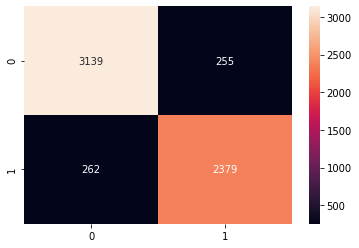

In [26]:
import seaborn as sns

sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt=".0f")

In [27]:
accuracy_score(y_test, pred)

0.9143330571665286